FIN-503 Advanced Derivatives

# Group U - Assignment 1

### Imports

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm   
from math import factorial
from scipy.optimize import brentq

import matplotlib.pyplot as plt
colors = ["blue", "orange", "green", "red"]

### Function definitions

In [2]:
def BS_call_price(S0, K, T, sigma, r, q):
    """
    Compute Black-Scholes price of EU call option (underlying follows classic drift/diffusion process)

    Parameters: 
    S0:     current stock price
    K:      strike
    T:      (time to) maturity
    sigma:  volatility
    r:      risk-free rate
    q:      dividend yield
    """
    
    d1 = (np.log(S0/K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    BS_call_price = S0 * np.exp(-q*T) * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)
    
    return BS_call_price

In [3]:
def Merton_call_price(S0, K, T, sigma, r, q, lam, gamma, max_jumps):
    """
    Compute Merton price of EU call option (underlying follows drift/diffusion/jump process)

    Parameters: 
    S0:     current stock price
    K:      strike
    T:      (time to) maturity
    sigma:  volatility
    r:      risk-free rate
    q:      dividend yield
    lam:    jump intensity
    gamma:  jump size
    """
    
    price = 0.0
    for j in range(max_jumps + 1):
        w_n = np.exp(-lam * T) * (lam*T)**j / factorial(j)     # weighting the average by the probability of hitting j jumps in [0, T]
        S_j = S0 * (1 + gamma)**j                              # using "adjusted" stock price
        price += w_n * BS_call_price(S_j, K, T, sigma, r, q + gamma * lam)

    return price

In [4]:
def implied_vol(price, S0, K, T, r, q, sigma_lower = 1e-8, sigma_upper = 5.0):
    """
    Given a call price, find the implied volatility (the vol. that would lead to that price if injected in BS model)
    --> Done through optimization using 'brentq'

    Parameters: 
    price:  price of the call
    S0:     current stock price
    K:      strike
    T:      (time to) maturity
    r:      risk-free rate
    q:      dividend yield
    """

    lower_bound = max(0.0, S0 * np.exp(-q*T) - K * np.exp(-r*T))
    upper_bound = S0 * np.exp(-q * T)
    
    if price <= lower_bound:
        return 0.0
    if price >= upper_bound:
        return np.nan

    def f(vol_optimizable):
        return BS_call_price(S0, K, T, vol_optimizable, r, q) - price

    try:
        return brentq(f, sigma_lower, sigma_upper, xtol=1e-12, rtol=1e-12, maxiter=200)
    except:
        return np.nan

### Results

In [5]:
# Global constant parameters 
S0 = 100
gamma = -0.08
lam = 0.2
sigma = 0.2
r = 0.04
q = 0
n_jumps = 3

# List of values to iterate through
maturity_vals = [0.02, 0.08, 0.25, 0.5]
moneyness_vals = [0.8, 0.9, 1.0, 1.1]
strike_vals = [i * S0 for i in moneyness_vals]

In [6]:
df_Merton_prices = pd.DataFrame(
    index = pd.Index(maturity_vals, name = "Maturity T"),
    columns = pd.Index(strike_vals, name = "Strike K"),
    dtype=float
)

df_BS_ivs = df_Merton_prices.copy()

for T in maturity_vals:
    for K in strike_vals:
        
        price = Merton_call_price(S0, K, T, sigma, r, q, lam, gamma, n_jumps)
        df_Merton_prices.loc[T, K] = price

        iv = implied_vol(price, S0, K, T, r, q)
        df_BS_ivs.loc[T, K] = iv

In [7]:
print("Call prices using Merton pricing formula")
display(df_Merton_prices)
print("\nImplied volatilities of latter prices")
display(df_BS_ivs)

Call prices using Merton pricing formula


Strike K,80.0,90.0,100.0,110.0
Maturity T,,,,
0.02,20.063975,10.073263,1.180217,0.000335
0.08,20.255798,10.357340,2.448866,0.133760
0.25,20.833514,11.519242,4.548771,1.177369
0.50,21.828737,13.216173,6.718297,2.830681



Implied volatilities of latter prices


Strike K,80.0,90.0,100.0,110.0
Maturity T,,,,
0.02,0.314027,0.250377,0.202110,0.200574
0.08,0.221457,0.207434,0.202905,0.201593
0.25,0.206156,0.204307,0.203221,0.202547
0.50,0.204523,0.203818,0.203307,0.202924


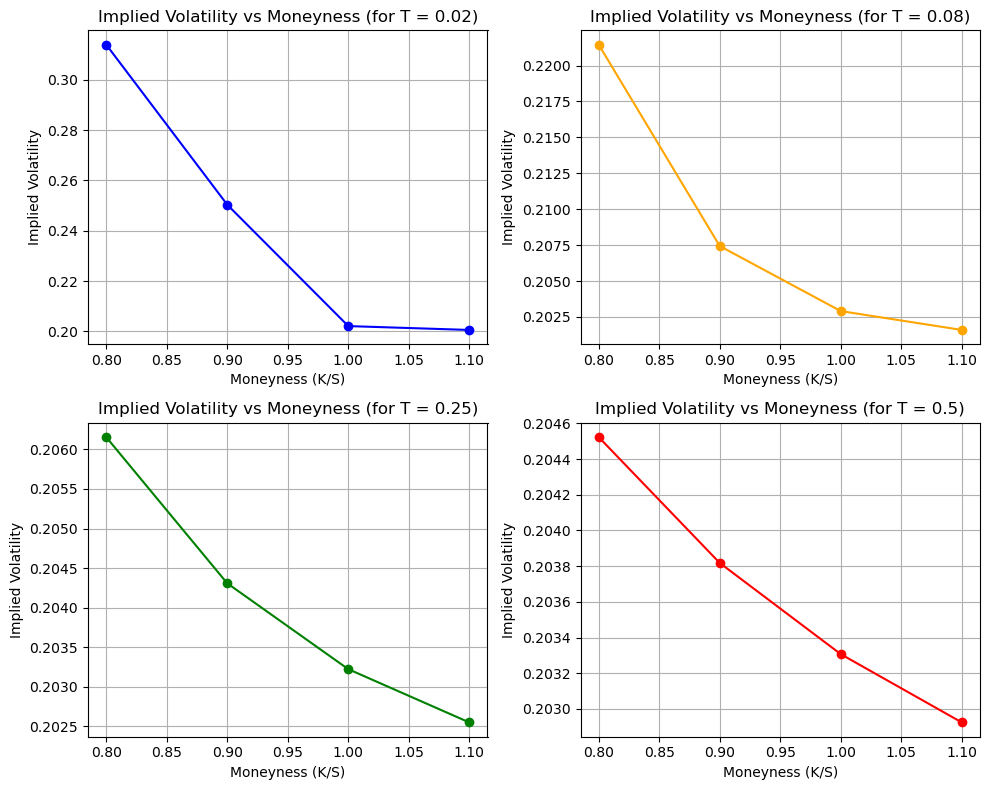

In [8]:
# 4 separate plots

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

for idx, T in enumerate(df_BS_ivs.index):
    i, j = divmod(idx, 2)
    ivs = df_BS_ivs.loc[T].values
    axes[i, j].plot(moneyness_vals, ivs, marker="o", color = colors[idx])
    axes[i, j].set_xlabel("Moneyness (K/S)")
    axes[i, j].set_ylabel("Implied Volatility")
    axes[i, j].set_title(f"Implied Volatility vs Moneyness (for T = {T})")
    axes[i, j].grid(True)

plt.tight_layout()
plt.show()

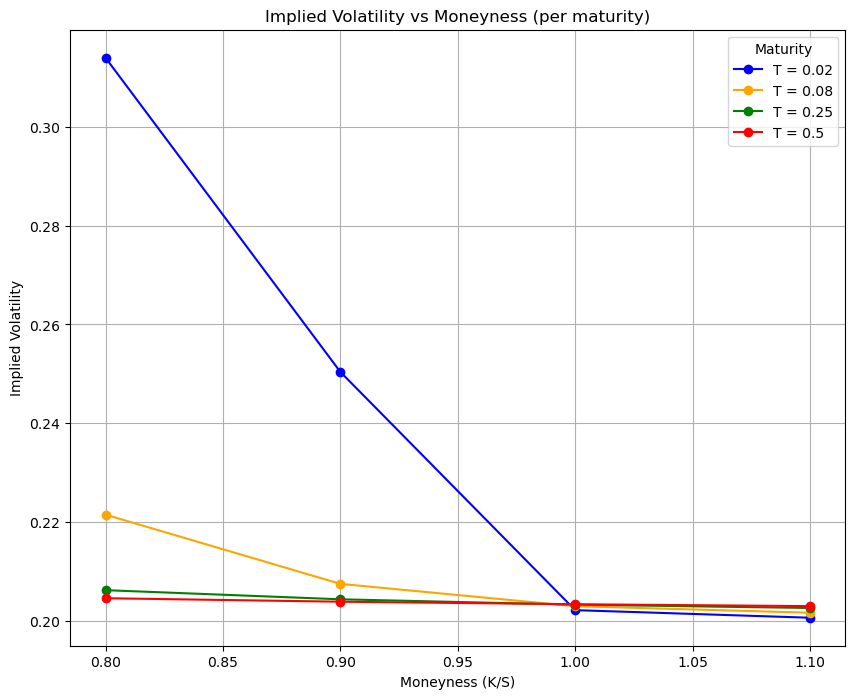

In [9]:
# Plot on the same y-scale

plt.figure(figsize=(10, 8))

for idx, T in enumerate(df_BS_ivs.index):
    ivs = df_BS_ivs.loc[T].values
    plt.plot(moneyness_vals, ivs, marker="o", label=f"T = {T}", color = colors[idx])

plt.xlabel("Moneyness (K/S)")
plt.ylabel("Implied Volatility")
plt.title("Implied Volatility vs Moneyness (per maturity)")
plt.legend(title="Maturity")
plt.grid(True)
plt.show()

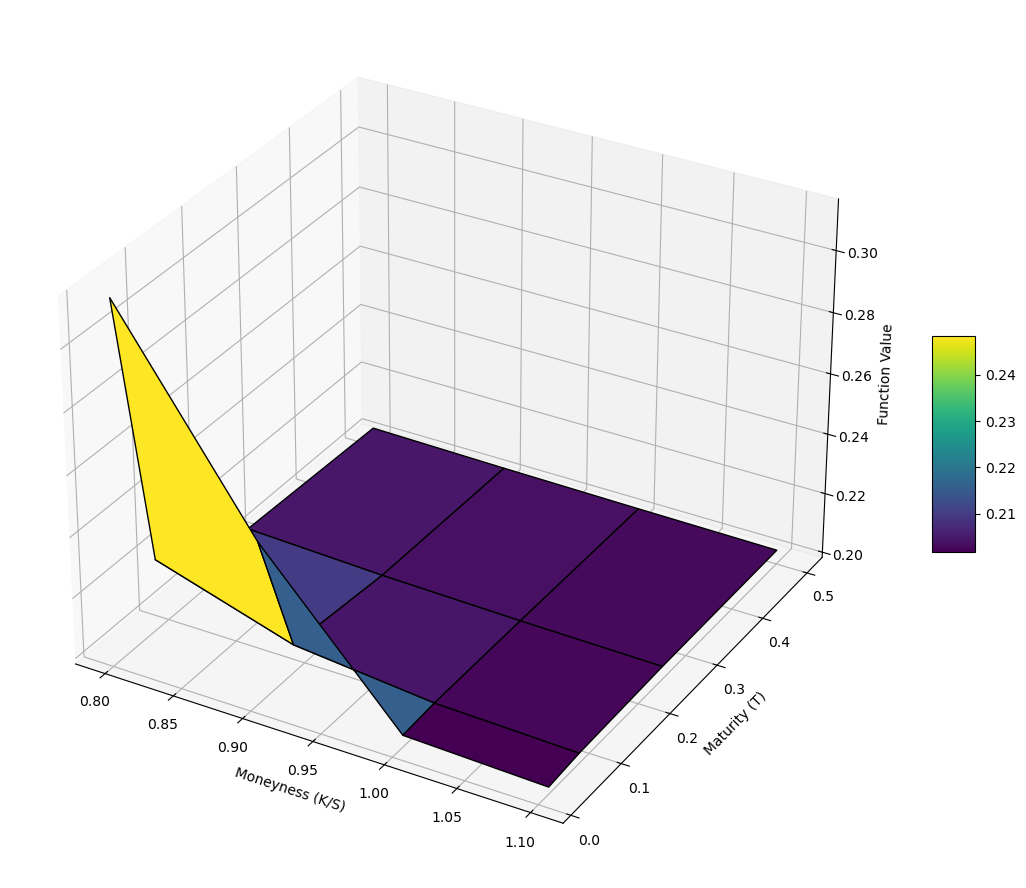

In [10]:
# 3D surface 

K_over_S_mesh, T_mesh = np.meshgrid(moneyness_vals, maturity_vals, indexing='ij')
Z = df_BS_ivs.values.T

fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(K_over_S_mesh, T_mesh, Z, cmap='viridis', edgecolor='k')

ax.set_xlabel('Moneyness (K/S)')
ax.set_ylabel('Maturity (T)')
ax.set_zlabel('Function Value')

fig.colorbar(surf, shrink=0.2, aspect=5)
plt.show()